<a href="https://colab.research.google.com/github/abhigoogol/Autoencoders-using-Pytorch/blob/master/03_Retinal_Vessel_Detection_Autoencoder_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download the dataset from https://www.isi.uu.nl/Research/Databases/DRIVE/download.php**

In [0]:
# NOTE: This link won't work because the download link has the validity for 1 day.
!wget --header="Host: www.isi.uu.nl" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.isi.uu.nl/Research/Databases/DRIVE/commence_download.php" --header="Cookie: _ga=GA1.2.775192014.1551372489; PHPSESSID=sta594dqntaabrs31138ubd2l1" --header="Connection: keep-alive" "https://www.isi.uu.nl/Research/Databases/DRIVE/free.php?usercode=GNP2H" -O "DRIVE.zip" -c

--2019-03-06 09:17:21--  https://www.isi.uu.nl/Research/Databases/DRIVE/free.php?usercode=GNP2H
Resolving www.isi.uu.nl (www.isi.uu.nl)... 143.121.214.137
Connecting to www.isi.uu.nl (www.isi.uu.nl)|143.121.214.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/download]
Saving to: ‘DRIVE.zip’

DRIVE.zip               [   <=>              ]  28.38M  65.8MB/s    in 0.4s    

2019-03-06 09:17:22 (65.8 MB/s) - ‘DRIVE.zip’ saved [29756930]



In [0]:
!ls -l
!unzip DRIVE.zip

In [0]:
!ls 

sample_data


# My code

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import random
from tqdm import tqdm_notebook

plt.style.use('default')

In [0]:
!ls DRIVE/training/
DATASET = 'DRIVE'
TRAIN = 'training'
TEST = 'test'
IMAGE_FOLDER = 'images'
LABEL_FOLDER = '1st_manual'

1st_manual  images  mask


In [0]:
class RetinalDataset(Dataset):
  def __init__(self, DATASET, FOLDER, IMAGE_FOLDER, LABEL_FOLDER, no_of_patches, pw, ph, transform=None):
    self.no_of_patches = no_of_patches
    self.pw, self.ph = pw, ph
    
    self.path = os.path.join(DATASET, FOLDER, IMAGE_FOLDER)
    self.images = sorted(os.listdir(self.path))
    
    self.label_path = os.path.join(DATASET, FOLDER, LABEL_FOLDER)
    self.label_images = sorted(os.listdir(self.label_path))
    
    self.transform = transform
   
  
  def make_patches(self, image, label_image, pw, ph, no_of_patches):
    # Convert PIL image to numpy array
#     image, label_image = np.array(image)/255.0, np.array(label_image)/255.0
    image, label_image = np.array(image), np.array(label_image)
    label_image = np.reshape(label_image, (label_image.shape[0], label_image.shape[1], 1))

    h, w = image.shape[0], image.shape[1]
    
    ImgArr = np.empty((patches, pw*ph*3))
    LabelArr = np.empty((patches, pw*ph*1))    
    for i in range(patches):
      ih = random.randint(0, h-ph)
      iw = random.randint(0, w-pw)
            
      imgArrI = np.copy(image[ih:ih+ph, iw:iw+pw, :])
      imgArrL = np.copy(label_image[ih:ih+ph, iw:iw+pw, :])
      ImgArr[i][:] = np.ravel(imgArrI)
      LabelArr[i][:] = np.ravel(imgArrL)

    return torch.tensor(ImgArr/255.0, dtype=torch.float32), torch.from_numpy(LabelArr/255.0)

  
  def __getitem__(self, idx):
    image = os.path.join(self.path, self.images[idx])
#     image = Image.open(image).convert('RGB')
    image = Image.open(image)
    
    label_image = os.path.join(self.label_path, self.label_images[idx])
#     label_image = Image.open(label_image).convert('L')
    label_image = Image.open(label_image)
    
    image, label_image = self.make_patches(image, label_image, self.pw, self.ph, self.no_of_patches)
    
#     if transform:
#       image = self.transform(image)
#       label_image = self.transform(label_image)
    
    return image, label_image
    
    
  def __len__(self):
    return len(self.images)

In [0]:
# transform = transform.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
transform = transforms.ToTensor()
bs = 20
patches = 1000
pw = 10
ph = 10
traindataset = RetinalDataset(DATASET, TRAIN, IMAGE_FOLDER, LABEL_FOLDER, patches, pw, ph, transform)
trainloader = DataLoader(traindataset, batch_size=bs, shuffle=True)

# testdataset = RetinalDataset(DATASET, TEST, IMAGE_FOLDER, LABEL_FOLDER, transform)
# testloader = DataLoader(testdataset, batch_size=bs)

In [0]:
i, l = next(iter(trainloader))
print(i.shape, l.shape)

torch.Size([20, 1000, 300]) torch.Size([20, 1000, 100])


In [0]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))

In [0]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(pw*ph*3, pw*ph),
                           nn.Tanh(),
                           nn.Linear(pw*ph, pw*ph),
                           nn.Tanh())
    self.decoder = nn.Sequential(nn.Linear(pw*ph, pw*ph),
                           nn.Tanh(),
                           nn.Linear(pw*ph, pw*ph*3),
                           nn.Sigmoid())
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x
    
net = Autoencoder()
print(net)

GPU = torch.cuda.is_available()
if GPU:
  net = net.cuda()

init_weights = copy.deepcopy(net.encoder[0].weight.data)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): Sigmoid()
  )
)


# Optimization Technique

In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# Train Autoencoder

In [0]:
epochs = 500
for epoch in tqdm_notebook(range(epochs)):
  runningloss = 0
  
  for images, labels in trainloader:
    if GPU:
      images, labels = Variable(images.view(images.shape[0]*images.shape[1], -1)).cuda(), Variable(labels.view(labels.shape[0]*labels.shape[1], -1)).cuda()
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, images)
    loss.backward()
    optimizer.step()
#     runningloss += loss.item()/images.shape[0]
    runningloss += loss.item()/20
  if epoch % 20 == 0:
    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

Epoch: 1/500 	 Mean Square Error Loss: 0.00018951305869268254
Epoch: 21/500 	 Mean Square Error Loss: 0.0001890186028787866
Epoch: 41/500 	 Mean Square Error Loss: 0.00018193155048647894
Epoch: 61/500 	 Mean Square Error Loss: 0.00017656196614261718
Epoch: 81/500 	 Mean Square Error Loss: 0.00016855547834420577
Epoch: 101/500 	 Mean Square Error Loss: 0.00016473615065915512
Epoch: 121/500 	 Mean Square Error Loss: 0.00016342731280019507
Epoch: 141/500 	 Mean Square Error Loss: 0.00015432412151712924
Epoch: 161/500 	 Mean Square Error Loss: 0.0001239508234197274
Epoch: 181/500 	 Mean Square Error Loss: 0.00011200587754137814
Epoch: 201/500 	 Mean Square Error Loss: 0.0001058476646663621
Epoch: 221/500 	 Mean Square Error Loss: 0.00010681484312517568
Epoch: 241/500 	 Mean Square Error Loss: 9.546385951107367e-05
Epoch: 261/500 	 Mean Square Error Loss: 0.00010927121561253444
Epoch: 281/500 	 Mean Square Error Loss: 0.00010004849772667512
Epoch: 301/500 	 Mean Square Error Loss: 9.5592102

# Modifying the autoencoder and training as Classifier

In [0]:
net

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): Sigmoid()
  )
)

In [0]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(pw*ph, pw*ph),
                                          nn.Sigmoid()))

print(net)
if GPU:
  net = net.cuda()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Sigmoid()
  )
)


In [0]:
labels.view(labels.size()[0], -1).shape

torch.Size([20000, 100])

In [0]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [0]:
epochs = 500
loss_list = []
for epoch in tqdm_notebook(range(epochs)):
  runningloss = 0
  
  for images, labels in trainloader:
    if GPU:
      images, labels = Variable(images.view(images.shape[0]*images.shape[1], -1)).cuda(), Variable(torch.tensor(labels, dtype=torch.float32).view(labels.shape[0]*labels.shape[1], -1)).cuda()

    output = net(images)
    optimizer.zero_grad()
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    runningloss += loss.item()/20
  
  loss_list.append(runningloss/(epoch+1))
  if epoch % 20 == 0:
    print('Epoch: {}/{} \t BCELoss: {}'.format(epoch+1, epochs, runningloss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch: 1/500 	 BCELoss: 0.014661368727684022
Epoch: 21/500 	 BCELoss: 0.014210985600948333
Epoch: 41/500 	 BCELoss: 0.014032292366027831
Epoch: 61/500 	 BCELoss: 0.013904888927936555
Epoch: 81/500 	 BCELoss: 0.01380547434091568
Epoch: 101/500 	 BCELoss: 0.013689948618412018
Epoch: 121/500 	 BCELoss: 0.013542653620243072
Epoch: 141/500 	 BCELoss: 0.013591821491718292
Epoch: 161/500 	 BCELoss: 0.013580188155174255
Epoch: 181/500 	 BCELoss: 0.013540394604206085
Epoch: 201/500 	 BCELoss: 0.013369527459144593
Epoch: 221/500 	 BCELoss: 0.01322626620531082
Epoch: 241/500 	 BCELoss: 0.01352866142988205
Epoch: 261/500 	 BCELoss: 0.013318122923374176
Epoch: 281/500 	 BCELoss: 0.013224758207798004
Epoch: 301/500 	 BCELoss: 0.013208739459514618
Epoch: 321/500 	 BCELoss: 0.013296028971672058
Epoch: 341/500 	 BCELoss: 0.01311867982149124
Epoch: 361/500 	 BCELoss: 0.01297498494386673
Epoch: 381/500 	 BCELoss: 0.012994895875453948
Epoch: 401/500 	 BCELoss: 0.013135915994644165
Epoch: 421/500 	 BCELoss

Text(0, 0.5, 'Loss')

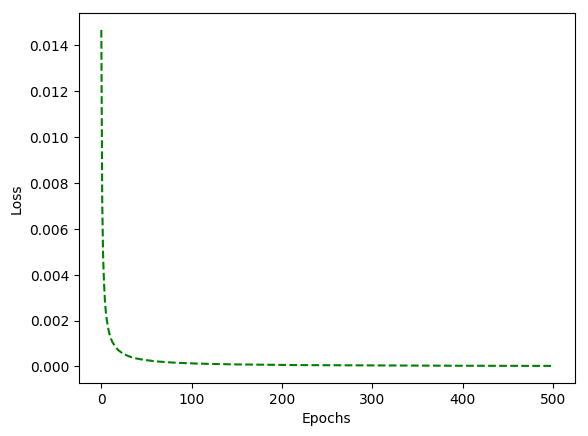

In [0]:
plt.plot(range(epochs), loss_list, 'g--', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Testing Performance

In [0]:
TestDatapath = 'DRIVE/test/images/'  # Test Image Data Path
TestLabelpath = 'DRIVE/test/1st_manual/'  # Test Image Manual Label

In [0]:
def make_patches(image, label_image, pw, ph, no_of_patches):
    # Convert PIL image to numpy array
    image, label_image = np.array(image)/255.0, np.array(label_image)/255.0

    imgArrOut = np.zeros((label_image.shape[0], label_image.shape[1]))
    print(imgArrOut.shape)
    for i in range(image.shape[0]-ph):
      for j in range(image.shape[1]-pw):
        imgArrI = np.copy(image[i:i+ph, j:j+pw, :])
        imgArrI = np.ravel(imgArrI)

        if GPU:
          images = Variable(torch.tensor(imgArrI, dtype=torch.float32)).cuda()
        output = net(images)
        imgArrOut[i:i+ph, j:j+pw] = output.view(10, 10).cpu().detach().numpy()
    return imgArrOut

# Load Images and Convert Images into numpy array
imD = Image.open(TestDatapath + '01_test.tif')
# imD = np.array(imD) 
# imD = imD/255.0 
imL = Image.open(TestLabelpath + '01_manual1.gif')
# imL = np.array(imL)
# imL = imL/255.0

out = make_patches(imD, imL, 10, 10, 1000)

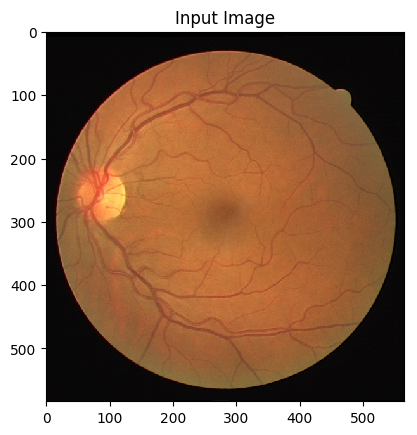

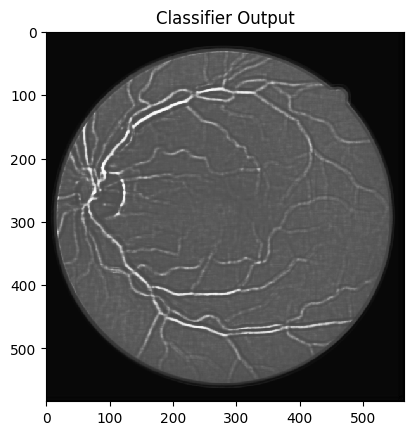

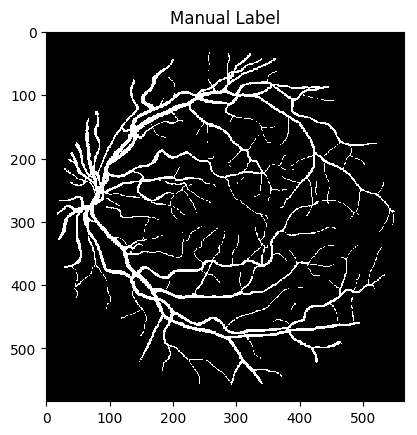

In [0]:
plt.figure()
plt.title('Input Image')
plt.imshow(imD)

plt.figure()
plt.title('Classifier Output')
plt.imshow(out, cmap='gray')

plt.figure()
plt.title('Manual Label')
plt.imshow(imL, 'gray')

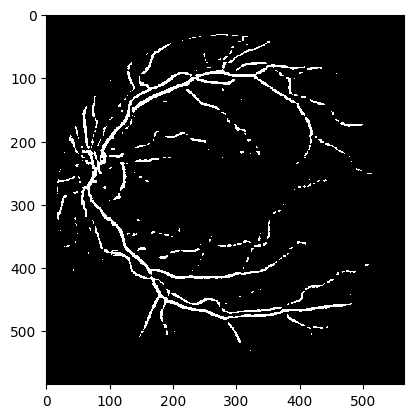

In [0]:
# Apply thresholding to convert to binary
O = (out >= .135) * 1
plt.imshow(O, cmap='gray')
plt.show()